## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

#### Note: Environment setup
Running this notebook requires an API key.

To use your API key locally, set the environment variable <i><b>PC_SDK_SUBSCRIPTION_KEY</i></b> or use <i><b>planetary_computer.settings.set_subscription_key(<YOUR API Key>)</i></b><br>
See <a href="https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed">when an account is needed for more </a>, and <a href="https://planetarycomputer.microsoft.com/account/request">request</a> an account if needed.

In [21]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.optimizers import Adam, RMSprop


# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('78e10f71f91b45669fa2d8ebfb3bb4fd')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

2023-03-15 23:18:56.631359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 23:18:56.797832: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 23:18:56.797884: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 23:18:57.950831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Response Variable

Before building the model, we need to load in the rice crop presence data. We have curated for you data from a certain region in Vietnam for the year 2020. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.  

In [ ]:
crop_presence_data = pd.read_csv("train-Landsat.csv")
crop_presence_data.head()

,Latitude_Longtitudes,time_frames,original_red,original_blue,original_green,original_ndvi,filter_red,filter_blue,filter_green,filter_ndvi,...,filter_swir,original_nir,filter_nir,original_savi,filter_savi,original_arvi,filter_arvi,original_evi,filter_evi,Class of Land
0,"(10.323727047081501, 105.2516346045924)",5/11/2021,0.262953,0.244643,0.276939,0.328094,0.070261,0.049645,0.093742,0.719424,...,13738.61185,0.519755,0.430577,0.300304,0.54002,0.297736,0.651443,0.508458,0.608718,Rice
1,"(10.323727047081501, 105.2516346045924)",10/11/2021,0.588294,0.623097,0.602272,0.079860,NaN,NaN,NaN,NaN,...,NaN,0.690412,NaN,0.086117,NaN,0.110073,NaN,0.466759,NaN,Rice
2,"(10.323727047081501, 105.2516346045924)",15/11/2021,0.305831,0.276924,0.322590,0.296068,NaN,NaN,NaN,NaN,...,NaN,0.563091,NaN,0.281893,NaN,0.254339,NaN,0.486811,NaN,Rice
3,"(10.323727047081501, 105.2516346045924)",15/11/2021,0.255717,0.220801,0.265357,0.345120,NaN,NaN,NaN,NaN,...,NaN,0.525242,NaN,0.315613,NaN,0.287555,NaN,0.480082,NaN,Rice
4,"(10.323727047081501, 105.2516346045924)",24/11/2021,0.171509,0.118053,0.177820,0.364883,NaN,NaN,NaN,NaN,...,NaN,0.368577,NaN,0.284209,NaN,0.241959,NaN,0.325790,NaN,Rice


## Data Cleaning

In [3]:
# remove all rows containing missing values

clean_df = crop_presence_data.dropna()
clean_df['ndvi_diff'] = clean_df['filter_ndvi']-clean_df['original_ndvi']

<AxesSubplot:xlabel='Class of Land', ylabel='count'>

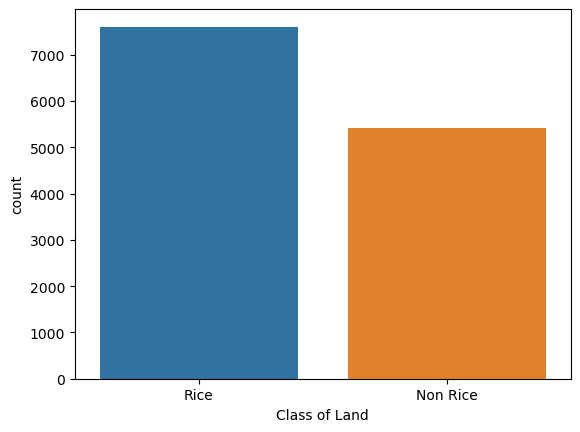

In [4]:
sns.countplot(clean_df, x = "Class of Land")

<AxesSubplot:>

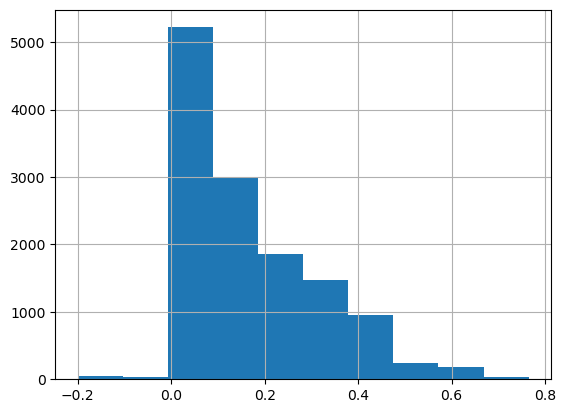

In [5]:
# ndvi_diff distribution

clean_df.ndvi_diff.hist()

In [6]:
clean_df['ndvi_diff'].describe()

count    13018.000000
mean         0.163576
std          0.152446
min         -0.200139
25%          0.034943
50%          0.121825
75%          0.259300
max          0.764991
Name: ndvi_diff, dtype: float64

***The image which is extreme cloud cover will be high in ndvi_diff. Hence, we only select those images with a minor difference (0.01) between original and filter ndvi.***

In [7]:
train_df = clean_df[abs(clean_df['ndvi_diff']) < 0.01][['Latitude_Longtitudes', 'filter_red', 'filter_blue', 'filter_green', 'filter_ndvi','filter_lir','filter_swir', 'Class of Land']]
train_df

,Latitude_Longtitudes,filter_red,filter_blue,filter_green,filter_ndvi,filter_lir,filter_swir,Class of Land
8,"(10.323727047081501, 105.2516346045924)",0.092907,0.057275,0.084791,0.212524,45598.39557,10793.40412,Rice
11,"(10.323727047081501, 105.2516346045924)",0.051911,0.034778,0.063384,0.500899,45202.09474,10077.26452,Rice
13,"(10.323727047081501, 105.2516346045924)",0.039902,0.034515,0.063465,0.739832,46421.41125,12434.09017,Rice
14,"(10.323727047081501, 105.2516346045924)",0.044293,0.043938,0.071451,0.741216,45832.37058,13068.04584,Rice
15,"(10.323727047081501, 105.2516346045924)",0.044855,0.044603,0.071715,0.775381,45795.40956,13557.84855,Rice
...,...,...,...,...,...,...,...,...
21867,"(10.013034527594062, 105.67361318732796)",0.048791,0.038609,0.063310,0.728989,42626.20906,12897.41261,Non Rice
21895,"(10.012580298764401, 105.67361318732796)",0.046837,0.036696,0.061814,0.740757,43034.82563,12805.70545,Non Rice
21896,"(10.012580298764401, 105.67361318732796)",0.048839,0.038646,0.063366,0.728819,42620.73324,12897.02078,Non Rice
21924,"(10.012126069934741, 105.67361318732796)",0.046861,0.036726,0.061856,0.740736,43030.03232,12804.53177,Non Rice


## Model Visualization

<AxesSubplot:xlabel='Class of Land', ylabel='count'>

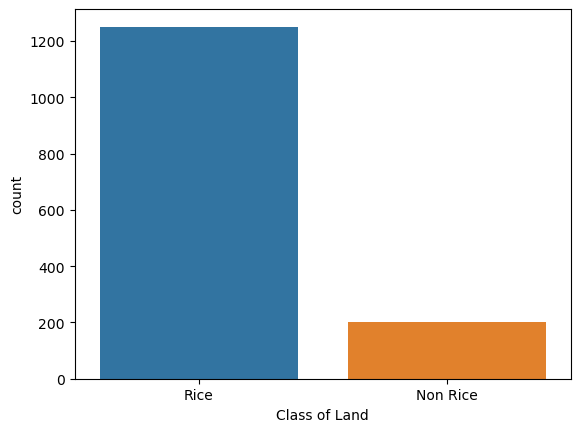

In [8]:
sns.countplot(train_df, x = 'Class of Land')

Text(0.5, 0.98, 'Frequency distribution of various bands')

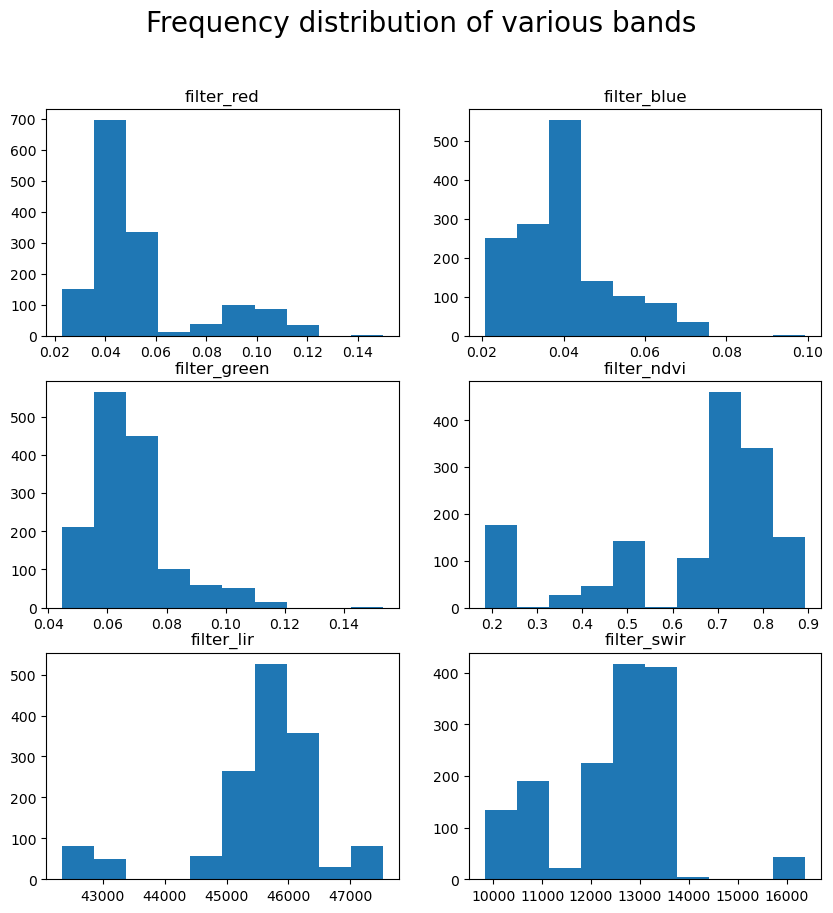

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(10,10))

features = ['filter_red', 'filter_blue', 'filter_green', 'filter_ndvi','filter_lir','filter_swir']
for i in range(len(features)):
    ax=axes[i//2, i%2]
    ax.hist(train_df[features[i]])
    ax.title.set_text(features[i])

fig.suptitle("Frequency distribution of various bands",  fontsize=20)

Text(0.5, 0.98, 'Frequency distribution of various bands')

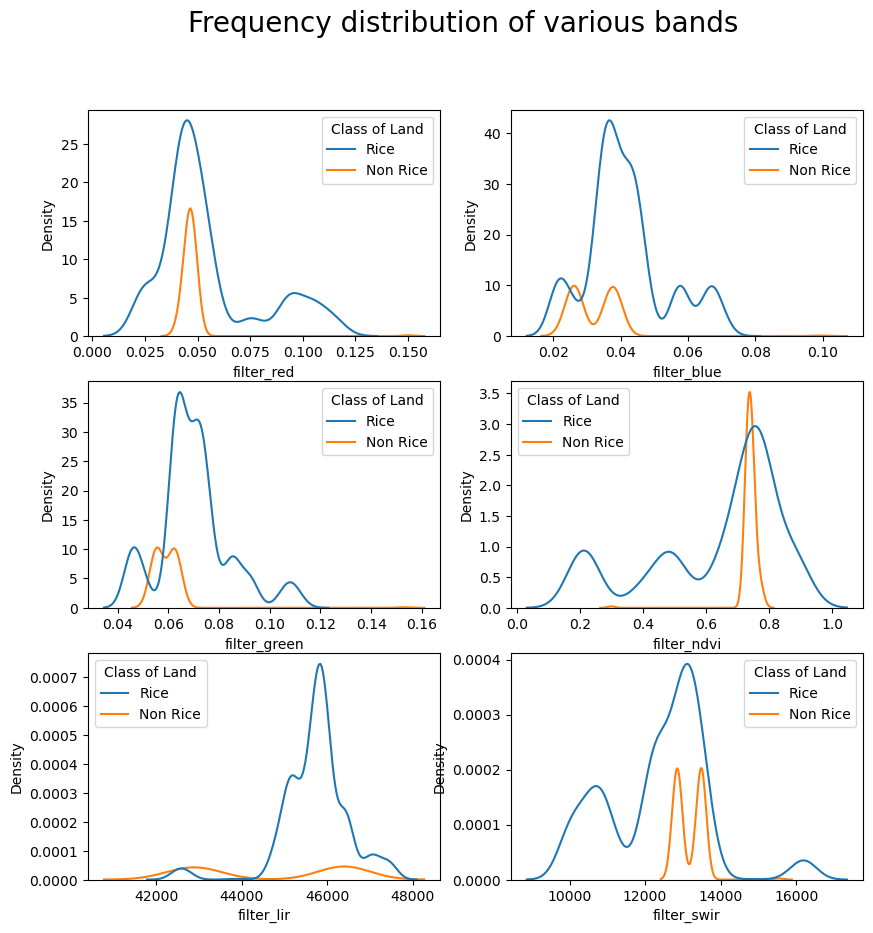

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(10,10))

features = ['filter_red', 'filter_blue', 'filter_green', 'filter_ndvi','filter_lir','filter_swir']
for i in range(len(features)):
    sns.kdeplot(data = train_df,x = features[i], hue = "Class of Land", ax=axes[i//2, i%2])

fig.suptitle("Frequency distribution of various bands",  fontsize=20)

In [11]:
cor_matrix=train_df[['filter_red', 'filter_blue', 'filter_green', 'filter_ndvi','filter_lir','filter_swir']].corr().round(decimals=1)
cor_matrix

,filter_red,filter_blue,filter_green,filter_ndvi,filter_lir,filter_swir
filter_red,1.0,0.9,0.9,-0.9,0.1,-0.2
filter_blue,0.9,1.0,1.0,-0.8,0.1,-0.1
filter_green,0.9,1.0,1.0,-0.7,0.1,-0.1
filter_ndvi,-0.9,-0.8,-0.7,1.0,-0.1,0.6
filter_lir,0.1,0.1,0.1,-0.1,1.0,0.1
filter_swir,-0.2,-0.1,-0.1,0.6,0.1,1.0


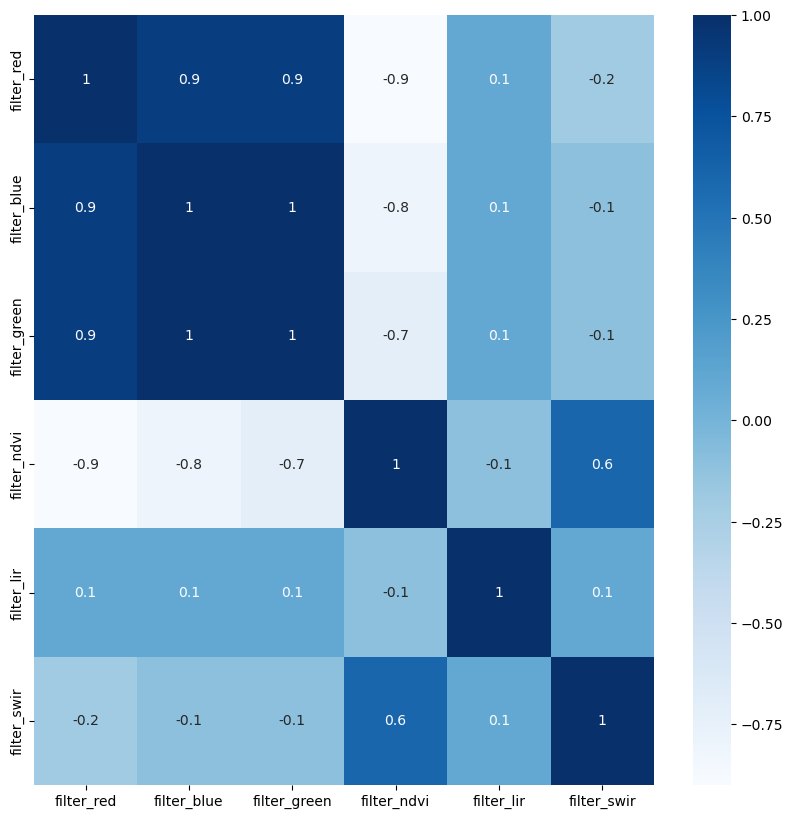

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(cor_matrix, annot = True, cmap='Blues', ax = ax)
plt.show()

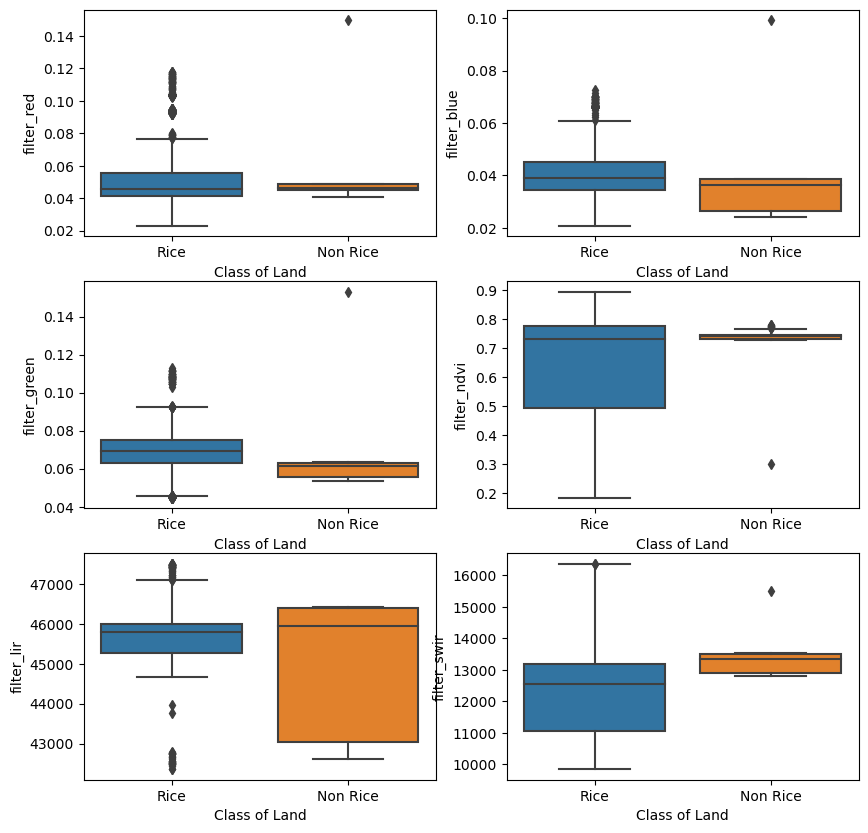

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
 
for i in range(len(features)):
    sns.boxplot(ax = axes[i//2, i%2], data=train_df, y=features[i], x="Class of Land")
plt.show() 

## Model Building


### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [28]:
train_df['Class of Land'] = np.where(train_df['Class of Land'] == 'Rice', 1, 0)

In [29]:
X = train_df.drop(columns=['Class of Land', 'Latitude_Longtitudes','filter_red', 'filter_blue','filter_green'])
y = train_df['Class of Land']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

In [30]:
X = X.reset_index().drop(columns = ['index'])
y = y.reset_index().drop(columns = ['index'])

### Feature Scaling 

In [31]:
sc = StandardScaler()
X_transform = sc.fit_transform(X)
#X_test = sc.transform(X_test)

In [18]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [32]:
initializer = tf.keras.initializers.HeNormal(seed=7)


In [33]:
model = Sequential()
model.add(Dense(16, input_dim=3, kernel_initializer=initializer,kernel_regularizer=l2(0.01), activation='relu'))
model.add(Dense(12, kernel_initializer=initializer,kernel_regularizer=l2(0.01), activation='relu'))
model.add(Dense(6, kernel_initializer=initializer, activation='relu'))

model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid'))
model.compile(optimizer= 'RMSprop', loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])

In [34]:
model.fit(X_train, y_train, epochs = 200, batch_size =512, verbose =2)


Epoch 1/200
2/2 - 1s - loss: 19972.8184 - accuracy: 0.1388 - f1_m: nan - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - 1s/epoch - 528ms/step
Epoch 2/200
2/2 - 0s - loss: 15911.7100 - accuracy: 0.1388 - f1_m: nan - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - 9ms/epoch - 4ms/step
Epoch 3/200
2/2 - 0s - loss: 13024.3633 - accuracy: 0.1388 - f1_m: nan - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - 10ms/epoch - 5ms/step
Epoch 4/200
2/2 - 0s - loss: 10571.6230 - accuracy: 0.1388 - f1_m: nan - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - 8ms/epoch - 4ms/step
Epoch 5/200
2/2 - 0s - loss: 8722.8867 - accuracy: 0.1388 - f1_m: nan - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - 8ms/epoch - 4ms/step
Epoch 6/200
2/2 - 0s - loss: 7314.1938 - accuracy: 0.1388 - f1_m: nan - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - 8ms/epoch - 4ms/step
Epoch 7/200
2/2 - 0s - loss: 6026.2915 - accuracy: 0.1388 - f1_m: nan - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - 9ms/epoch - 5ms/step


In [36]:
from sklearn.metrics import confusion_matrix
y_predict = np.where(model.predict(X_train) >= 0.5,1,0)
confusion_matrix(y_train, y_predict)

32/32 [==============================] - 0s 1ms/step


array([[  0, 141],
       [  0, 875]])

In [38]:

from sklearn.metrics import classification_report
print(classification_report(y_train, y_predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.86      1.00      0.93       875

    accuracy                           0.86      1016
   macro avg       0.43      0.50      0.46      1016
weighted avg       0.74      0.86      0.80      1016



### Model Training

<p justify ="align">Now that we have the data in a format appropriate for machine learning, we can begin training a model. In this demonstration notebook, we have used a binary logistic regression model from the scikit-learn library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</p>

<p justify ="align">Scikit-learn models require separation of predictor variables and the response variable. You have to store the predictor variables in array X and the response variable in the array Y. You must make sure not to include the response variable in array X. It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.</p>

In [39]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train,y_train)

LogisticRegression()

In [40]:
from sklearn.model_selection import StratifiedKFold

In [41]:
def model_evaluation(models, X, y):
    names = []
    f1_mean = []
    
    for name, model in models:
        names.append(name)
        f1 = []

        skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            # Split the dataset
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]
            
            
            # Fit the model with the training set
            model.fit(X_train, y_train)
            
            # Calculate F1 score
            y_pred = model.predict(X_test)
            f1.append(f1_score(y_test, y_pred))
                
        f1_mean.append(np.mean(f1).round(7))
    
    return names, f1_mean

In [42]:
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            # Split the dataset
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]

In [45]:
# Import all the functions and objects we want to test
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
#from pyearth import Earth
#from pygam import LogisticGAM
import statsmodels.api as sm

In [44]:
!pip install xgboost

  Using cached xgboost-1.7.4-py3-none-manylinux2014_x86_64.whl (193.6 MB)


In [46]:
models = []
# Decision Tree Classifier
models.append(('CART', DecisionTreeClassifier()))

#XGBoost
models.append(('XGB', XGBClassifier()))

# Random Forest Classifier
models.append(('RFC', RandomForestClassifier()))


In [47]:
names, f1_mean = model_evaluation(models, X_transform, y)
list_of_tuples = list(zip(names, f1_mean))

summary = pd.DataFrame(list_of_tuples, columns = ['Name','F1 score']) 
summary

,Name,F1 score
0,CART,0.998406
1,XGB,0.998807
2,RFC,0.999601


In [83]:
X_transform

array([[-1.99505609, -0.16581384, -1.16669795],
       [-0.63165259, -0.67257772, -1.70073169],
       [ 0.49799561,  0.88660542,  0.05678099],
       ...,
       [-0.00947917, -0.46076889, -0.47082302],
       [ 0.6660386 , -1.16401712,  0.66162849],
       [ 0.67352801, -0.85417057,  0.72603278]])

In [48]:
model = RandomForestClassifier()

In [49]:
model.fit(X,y)

RandomForestClassifier()

In [50]:
y['Class of Land'] = y['Class of Land'].astype('int')

In [51]:
from sklearn.model_selection import StratifiedShuffleSplit

skf = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

In [52]:
y = y['Class of Land'].reset_index(drop=True)


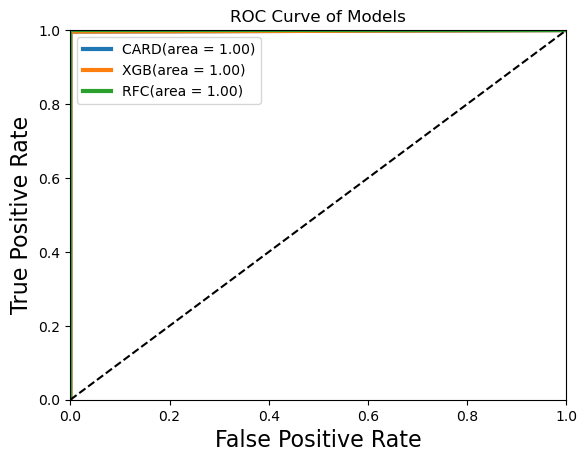

<Figure size 1000x600 with 0 Axes>

In [71]:
# Decision Tree Classifier
cart = DecisionTreeClassifier()
cart.fit(X_train, y_train)
y_score_cart = cross_val_predict(cart, X_test, y_test, cv=10)
fpr_cart, tpr_cart, threshold_cart = roc_curve(y_test,y_score_cart)


# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_score_xgb = cross_val_predict(xgb, X_test, y_test, cv=10)
fpr_xgb, tpr_xgb, threshold_xgb = roc_curve(y_test,y_score_xgb)


# Random Forest
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_score_rfc = cross_val_predict(rfc, X_test, y_test, cv=10)
fpr_rfc, tpr_rfc, threshold_rfc = roc_curve(y_test,y_score_rfc)




# ROC Curve for the models above
plt.plot(fpr_cart, tpr_cart, linewidth = 3, label='CARD(area = %0.2f)' % roc_auc_score(y_test,y_score_cart))
plt.plot(fpr_xgb, tpr_xgb, linewidth = 3, label='XGB(area = %0.2f)' % roc_auc_score(y_test,y_score_xgb))
plt.plot(fpr_rfc, tpr_rfc, linewidth = 3, label='RFC(area = %0.2f)' % roc_auc_score(y_test,y_score_rfc))

plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve of Models')
plt.figure(figsize=(10, 6))
plt.show()

## Model Evaluation

Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the classification report and will plot the confusion matrix. Scikit-learn provides many other metrics that can be used for evaluation. You can even write a code on your own.

### In-Sample Evaluation
<p align="Jutisfy"> We will be generating a classification report and a confusion matrix for the training data. It must be stressed that this is in-sample performance testing , which is the performance testing on the training dataset. These metrics are NOT truly indicative of the model's performance. You should wait to test the model performance on the test data before you feel confident about your model.</p>

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model. 

In [72]:
insample_predictions = model.predict(X_train)

In [73]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      1161
   macro avg       1.00      1.00      1.00      1161
weighted avg       1.00      1.00      1.00      1161



<p> For plotting a confusion matrix we define the function <b><i>plot_confusion_matrix</i></b>.

In [74]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

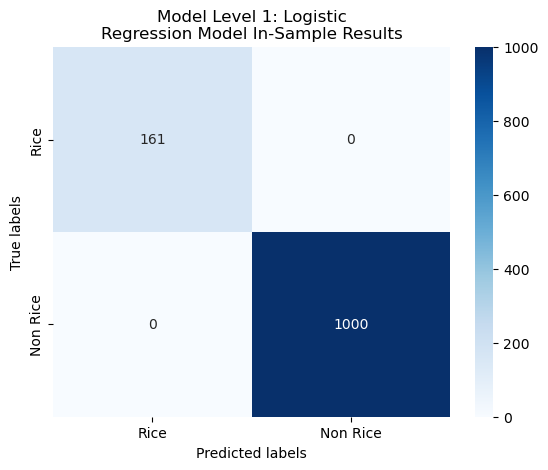

In [75]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Logistic\nRegression Model In-Sample Results",['Rice', 'Non Rice'])

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [76]:
outsample_predictions = model.predict(X_test)

In [77]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00       251

    accuracy                           1.00       291
   macro avg       1.00      1.00      1.00       291
weighted avg       1.00      1.00      1.00       291



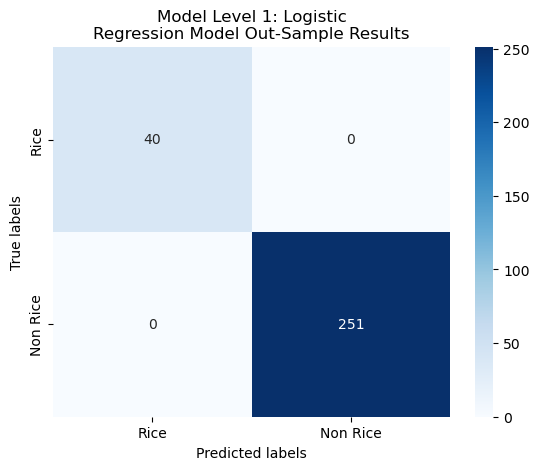

In [78]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

From the above, we see that the model is able to achieve an F1 score of <b>0.57</b>. This is not a very good score, so your goal is to improve this score.  

## Submission

In [79]:
test_file = pd.read_csv('test_df_landsat.csv')

In [80]:
test_file.shape

(17396, 15)

In [81]:
test_file.Latitude_Longtitudes.value_counts().count()

250

In [82]:
test_file = test_file.dropna()

In [83]:
test_file.Latitude_Longtitudes.value_counts().count()

250

In [84]:
test_file['ndvi_diff'] = test_file['filter_ndvi']-test_file['original_ndvi']

In [85]:
features

['filter_red',
 'filter_blue',
 'filter_green',
 'filter_ndvi',
 'filter_lir',
 'filter_swir']

In [419]:
#index = test_file.groupby(by = 'Latitude_Longtitudes').ndvi_diff.idxmin()

In [86]:
test_filev1 = test_file[abs(test_file['ndvi_diff']) < 0.06][['Latitude_Longtitudes', 'filter_red', 'filter_blue', 'filter_green', 'filter_ndvi','filter_lir','filter_swir']]
test_filev1

,Latitude_Longtitudes,filter_red,filter_blue,filter_green,filter_ndvi,filter_lir,filter_swir
7,"(10.18019073690894, 105.32022315786804)",0.086730,0.053219,0.082083,0.294297,45855.65536,10309.69790
8,"(10.18019073690894, 105.32022315786804)",0.062594,0.046777,0.075491,0.558063,45467.50337,12299.84453
10,"(10.18019073690894, 105.32022315786804)",0.057414,0.049139,0.081931,0.697658,46133.74772,13458.57528
11,"(10.18019073690894, 105.32022315786804)",0.034750,0.030562,0.058250,0.827100,44785.45743,13554.81350
14,"(10.18019073690894, 105.32022315786804)",0.053849,0.054598,0.082342,0.793171,45288.45603,15176.38828
...,...,...,...,...,...,...,...
17357,"(10.574733898351617, 105.10410108072531)",0.029137,0.025462,0.054369,0.864572,46080.73913,13431.26334
17361,"(10.574733898351617, 105.10410108072531)",0.042748,0.032703,0.065481,0.814262,45460.37676,13059.23156
17363,"(10.574733898351617, 105.10410108072531)",0.036305,0.025378,0.055345,0.822577,45779.00203,12216.46677
17371,"(10.574733898351617, 105.10410108072531)",0.086027,0.049774,0.084050,0.343944,47059.16203,11866.19855


In [87]:
test_filev1.Latitude_Longtitudes.value_counts().count()

250

In [88]:
final_df = test_filev1[['filter_ndvi','filter_lir','filter_swir']]

In [89]:
sc = StandardScaler()
final_df_transform = sc.fit_transform(final_df)


In [90]:
from sklearn.metrics import confusion_matrix
y_predict = np.where(model.predict(final_df_transform) >= 0.5,1,0)


In [91]:
test_filev1['predict'] = y_predict

In [92]:
test_filev1.groupby(by='Latitude_Longtitudes').predict.mean()

Latitude_Longtitudes
(10.15475392244798, 105.29932863170458)     1.0
(10.157025066596281, 105.31250126776416)    1.0
(10.159296210744582, 105.31204703893451)    1.0
(10.160204668403901, 105.29524057223784)    1.0
(10.16111312606322, 105.29433211457857)     1.0
                                           ... 
(10.823197068175638, 105.20403142324611)    1.0
(10.823651297005297, 105.20312296558683)    1.0
(10.823651297005297, 105.20357719441648)    1.0
(10.823651297005297, 105.20403142324611)    1.0
(10.824105525834957, 105.20403142324611)    1.0
Name: predict, Length: 250, dtype: float64

Once you are happy with your model, you can make a submission. To make a submission, you will need to use your model to make predictions about the presence of rice crops for a set of test coordinates we have provided in the <a href="https://challenge.ey.com/api/v1/storage/admin-files/6847912254281276-63ca8b5ab12e510013520e2b-challenge_1_submission_template.csv"><b>"challenge_1_submission_template.csv"</b></a> file and upload the file onto the challenge platform.

In [94]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template.csv')
test_file.head()

,id,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN


In [95]:
test_filev1.groupby(by='Latitude_Longtitudes').predict.mean().values>0.4

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [97]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'id':test_file['id'].values, 'target':test_filev1.groupby(by='Latitude_Longtitudes').predict.mean().values>=0.4})

In [98]:
#Displaying the sample submission dataframe
display(submission_df)

,id,target
0,"(10.18019073690894, 105.32022315786804)",True
1,"(10.561107033461816, 105.12772097986661)",True
2,"(10.623790611954897, 105.13771401411867)",True
3,"(10.583364246115156, 105.23946127195805)",True
4,"(10.20744446668854, 105.26844107128906)",True
...,...,...
245,"(10.308283266873062, 105.50872812216863)",True
246,"(10.582910017285496, 105.23991550078767)",True
247,"(10.581547330796518, 105.23991550078767)",True
248,"(10.629241357910818, 105.15315779432643)",True


In [99]:
submission_df['target'] = submission_df['target'].astype('int')

In [100]:
submission_df

,id,target
0,"(10.18019073690894, 105.32022315786804)",1
1,"(10.561107033461816, 105.12772097986661)",1
2,"(10.623790611954897, 105.13771401411867)",1
3,"(10.583364246115156, 105.23946127195805)",1
4,"(10.20744446668854, 105.26844107128906)",1
...,...,...
245,"(10.308283266873062, 105.50872812216863)",1
246,"(10.582910017285496, 105.23991550078767)",1
247,"(10.581547330796518, 105.23991550078767)",1
248,"(10.629241357910818, 105.15315779432643)",1


In [101]:
def transform(x):
    if x == 1:
        return "Rice"
    else:
        return "Non Rice"

In [102]:
submission_df['target'] = submission_df['target'].apply(lambda x: transform(x) )

In [103]:
submission_df.target.value_counts()


Rice    250
Name: target, dtype: int64

In [104]:
submission_df

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Rice
246,"(10.582910017285496, 105.23991550078767)",Rice
247,"(10.581547330796518, 105.23991550078767)",Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [105]:
#Dumping the predictions into a csv file.
submission_df.to_csv("try0.csv",index = False)

## Conclusion

Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!